<img src="https://www.th-koeln.de/img/logo.svg" style="float: right;" width="200">

# 11th exercise: <font color="#C70039">Learning and using word embeddings</font>
* Course: DIS21a.1
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook modifications and adaptations: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   17.01.2023
* Name: Laura Fredrich
* MAtrikelnr.: 11148559

<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs12115-019-00362-9/MediaObjects/12115_2019_362_Fig2_HTML.png?as=webp" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information about your tasks (e.g. regarding the set of certain paramaters or specific computational tricks, etc.), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation (for instance, after you have run through your test plan) you may use German language.
This applies to all exercises in DIS 21a.1.  

---------------------

### <font color="ce33ff">DESCRIPTION</font>:

This notebook allows for learning how to create and use word embeddings as another popular and powerful way for associating a word with a vector. While the vectors obtained through one-hot encoding are binary and sparse, which means mostly made of zeros as well as high-dimensional, which means show the same dimensionality as the number of words in the vocabulary, "word embeddings" are low-dimensional floating point vectors. In other words these are dense vectors, in contrast to sparse vectors. 
Unlike word vectors created by one-hot encoding, word embeddings are `learned` from data. It is common to see word embeddings that are 256-dimensional, 512-dimensional or 1024-dimensional when dealing with very large vocabularies. On the other hand, one-hot encoding words generally leads to vectors that are 20.000-dimensional or higher (capturing a vocabulary of 20.000 
token in this case). So, word embeddings pack more information into far fewer dimensions. 

There are two ways to get word embeddings:

1. Learn word embeddings jointly with the main task, for example document classification or sentiment prediction as already done in the previous exercises. 
    * start with random word vectors, then learn word vectors in the same way the weights of a neural network are learned.
2. Load into the model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
    * these are called "pre-trained word embeddings"

Each of them is taught in a separate PART of this notebook.

So let's go for it.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
Within this notebook, the tasks that you need to work on are always listed as bullet points below. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook before submitting it.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully. 
    * add comments whereever you feel it necessary for better understanding.
    * run the notebook and try to follow and understand all steps and examples.
4. in PART II, try to randomly pick different (n=200) training samples and try to find a model. Compare its performance.
    * develop a testplan as you have done before, so you do not change parameters arbitrarily and use a table for the validation results. 
5. in PART II, increase the number of training samples for the task-specific embedding and compare it again with the pre-trained embedding. Does it become better? When does it beat the pre-trained embedding?
    * develop a testplan as you have done before, so you do not change parameters arbitrarily and use a table for the validation results
    
-----------------------------------------------------------------------------------

## <font color="#C70039">PART I</font>
### Learning word embeddings with the `Embedding` layer

The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the resulting embedding space would have no structure and that the words "accurate" and "exact" may end up with completely different embeddings even though they are interchangeable in many sentences. It would be very difficult for a deep neural network to make sense of such a noisy, unstructured embedding space. 

This is why within a good embedding space a geometric relationships between word vectors should reflect the semantic relationships between these words. Hence it would to be expected that the geometric distance (e.g. L2 distance) between any two word vectors do relate to the semantic distance of the associated words. I.e., words meaning very different things would be embedded to points far away from each other, while related words would be closer.

However, pragmatically seen, what makes a good word embedding space depends heavily on the task at hand. Thus the perfect word embedding space for an English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language legal document classification model, because the importance of certain semantic relationships varies from task to task. It is thus reasonable to learn a new embedding space with every new task. 

Thanks to backpropagation this learning is really easy and thanks to Keras it becomes even easier. 
Finally it is just about learning the weights of a layer, the so-called `Embedding` layer and this is what PART I is all about.

### START OF THE NOTEBOOK CODE
----------------------------------------------------------------------------------------------------------------------

In [1]:
import tensorflow
tensorflow.keras.__version__

'2.9.0'

In [2]:
from tensorflow.keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input those integers, it looks them up in an internal dictionary and finally, it returns the associated vectors. Hence, it is effectively a dictionary lookup.

The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths, so e.g. one could feed into the embedding layer above batches that could have shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). Note that all sequences in a batch must have the same length since they need to be packed into a single tensor and so, sequences  shorter than others should be padded (filled-in) with zeros and sequences that are longer should be truncated (cut).

The layer above returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then be processed by a recurrent (RNN) or a convolution layer (CNN). For the RNN case see next exercise.

When instantiating an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just as always like with any other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, the trained embedding space will show a lot of structure - a kind of structure specialized for the specific problem at hand.

-----------

Now, let us apply this idea to the IMDB movie review sentiment prediction task from the earlier exercise.
Quickly prepare the data. The movie reviews will be restricted to the top 10.000 most common words (like the first time when working with this data set), and then the reviews are cut off after only 20 words. <br>
The network will simply learn 8-dimensional embeddings for each of the 10.000 words, then turn the input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D and train a single `Dense` layer on top for classification.

In [3]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns the lists of integers into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 [==============================] - 0s 0us/step


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()
# Specify the maximum input length to the Embedding layer
# Later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, the activations have shape `(samples, maxlen, 8)`.

# Flatten the 3D tensor of embeddings into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# Add the classifier on top with a single Dense layer
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

# use the history object again
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 3s 3ms/step - loss: 0.6677 - acc: 0.6273 - val_loss: 0.6144 - val_acc: 0.6968
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5386 - acc: 0.7524 - val_loss: 0.5232 - val_acc: 0.7326
Epoch 3/10
625/625 [==============================] 

The validation accuracy is about 72-76%, which is pretty good considering that only the first 20 words in every review were taken into account. 

But note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the input sequence separately, without considering inter-word relationships and structured sentences (for example it would treat both _"this movie is shit"_ and _"this movie is the shit"_ as being negative "reviews" which is obviously not true). 

It would be much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole. However, that's the content of the next exercise.

----------------------------------------------------

## <font color="#C70039">PART II</font>
### Using `pre-trained` word embeddings

Instead of learning word embeddings jointly with the problem, embedding vectors can be loaded from a pre-computed embedding space known to be highly structured and to exhibit useful properties that captures generic aspects of language structure. 

The reseaon behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained CNNs in image classification. There is simply not enough data available to learn truly powerful features on its own but it is expected that the features needed are fairly generic, i.e. common visual features or semantic features. In this case it makes sense to re-use features learned on a different problem.

Such word embeddings are generally computed using word occurrence statistics which are observations about what words co-occur in sentences or documents, using a variety of techniques, some involving neural networks, others not. 
The idea of a dense, low-dimensional embedding space for words computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec algorithm, developed by Mikolov at Google in 2013.<br>

There are various pre-computed databases of word embeddings that can be downloaded and started with using a Keras `Embedding` layer. "Word2Vec" is one of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. 
It stands for "Global Vectors for Word Representation" and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from common crawl data.

Let us take a look at how GloVe embeddings in a Keras model can be used. The same method will of course be valid for Word2Vec embeddings or any other word embedding database. 

### START OF THE NOTEBOOK CODE
----------------------------------------------------------------------------------------------------------------------

## Putting it all together: from raw text to word embeddings

Use a model similar to the one that was just used earlier -- embedding sentences in sequences of vectors, flattening them and training a `Dense` layer on top. But now, this will be done using pre-trained word embeddings and instead of using the pre-tokenized IMDB data packaged in Keras it will be started from scratch by downloading the original text data.

### Download the IMDB data as raw text

First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB data set. Anyways, this data set is distributed and available all over the web and can be found anywhere. After downloading, uncompress it.

Now, using some lines of code, collect the individual training reviews into a list of strings, one string per review, and also collect the review labels (positive / negative) into a `labels` list. Make sure you are uploading the data to your Google Drive if you are using Google Colab.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


NOTE: Aufgrund der hohen Datenmenge des IMDB-Datasets und der damit verbundenen sehr langen Upload-Zeit in Google-drive, wurden die Datensets immer auf 500 Dateien pro Ordner gekürzt. Da nur 200 samples verwendet werden, birgt sich kein Nachteil. 

In [7]:
import os

imdb_dir = '/content/drive/MyDrive/Programming/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenization

Vectorize the texts and prepare a training and validation split. Use the same concepts that were introduced earlier in the notebook of exercise #10.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available, add the following restriction (otherwise, task-specific embeddings are always outperforming them): 

* restrict the training data to its first 200 samples only. Hence, try to let the model learn to classify movie reviews after looking at just 200 examples. That is almost nothing and we will see how far we can get with this. 

In [117]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # cut reviews after 100 words
training_samples = 500  # training on 200 samples only
validation_samples = 10000  # validation on 10000 samples
max_words = 10000  # consider the top 10000 words in the data set

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since the data samples are 
# ordered (all negative first, then all positive)
''' NOTE: Better always shuffle if you are not sure data is ordered'''
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 17574 unique tokens
Shape of data tensor: (1000, 100)
Shape of label tensor: (1000,)


### Downloading the GloVe word embeddings

Please visit `https://nlp.stanford.edu/projects/glove/` and download the pre-computed embeddings from 2014 English Wikipedia. 
By the way, this site is an excellent ressource for further reading where you can learn more about the GloVe algorithm. 
The pre-computed embeddings are packed together in a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 400.000 words. Unzip it and put it into the local disk data folder. Since its size is too large for Moodle, I recommend to download it yourself. If you are working on Google Colab please upload the necessary file "glove.6B.100d.txt" into your Google drive rather than the entire zip file content.

### Preprocessing the embeddings

Parse the unzipped file to build an index, mapping words (as strings) to their vector representation (as number vectors).

In [118]:
glove_dir = '/content/drive/MyDrive/Programming'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors' % len(embeddings_index))

Found 400000 word vectors


Now, build an embedding matrix that can be loaded into an `Embedding` layer. It must be a matrix of shape `(max_words,embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index (built during tokenization). Note that the index `0` is not supposed to stand for any word or token. It is simply a placeholder.

In [119]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in the embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector

### Model definition

Use the same model architecture as before, using a Dense layer.

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 flatten_21 (Flatten)        (None, 10000)             0         
                                                                 
 dense_41 (Dense)            (None, 32)                320032    
                                                                 
 dense_42 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Loading the GloVe embeddings in the model

The `Embedding` layer has got a single weight matrix. It is a 2D float matrix where each entry `i` is the word vector meant to be associated with index `i`. Simple enough! Load the GloVe matrix into the `Embedding` layer, which is the first layer in the model.

In [121]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Additionally, freeze the embedding layer by setting its `trainable` attribute to `False`, following the same idea that we are already familiar with in the context of pre.trained CNN features in the earlier exercise. The idea was that when parts of a model are pre-trained like this `Embedding` layer and parts are randomly initialized like this classifier, then the pre-trained parts should not be updated during training to avoid forgetting what they already know. 
The large gradient update triggered by the randomly initialized layers would be very disruptive to the already learned features.

### Training and evaluating

Compile the model and then train and validate it in one pass.

In [122]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=8,
                    validation_data=(x_val, y_val))

model.save_weights('Ex.11.pretrained_GloVe_model.h5')

Epoch 1/5
63/63 [==============================] - 2s 13ms/step - loss: 0.8690 - acc: 0.5380 - val_loss: 1.4450 - val_acc: 0.5040
Epoch 2/5
63/63 [==============================] - 0s 7ms/step - loss: 0.4959 - acc: 0.7980 - val_loss: 0.7631 - val_acc: 0.5720
Epoch 3/5
63/63 [==============================] - 0s 7ms/step - loss: 0.2150 - acc: 0.9280 - val_loss: 1.4821 - val_acc: 0.5080
Epoch 4/5
63/63 [==============================] - 0s 7ms/step - loss: 0.1554 - acc: 0.9500 - val_loss: 1.4122 - val_acc: 0.5580
Epoch 5/5
63/63 [==============================] - 0s 8ms/step - loss: 0.0566 - acc: 0.9880 - val_loss: 0.9295 - val_acc: 0.6440


Plot its performance

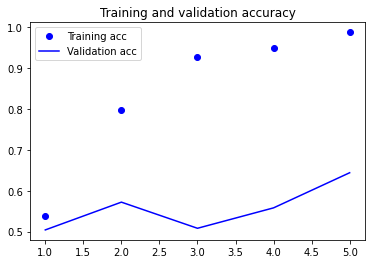

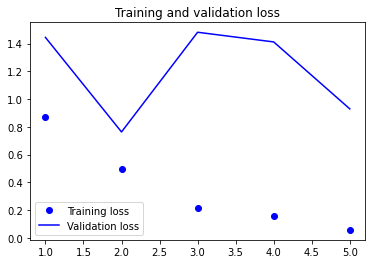

In [123]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model quickly starts overfitting which is not surprising due to the small number of training samples. Validation accuracy has high variance for the same reason but seems to reach high 50s.

Note that the precision may vary since there are so few training samples, that performance heavily depends on which exact 200 samples were picked and in this example they were picked at random (see your task list). 

----------------
### Another attempt
We can also try to train the same model <u>without</u> loading the pre-trained word embeddings and <u>without</u> freezing the embedding layer. In that case, it will result in learning a task-specific embedding of the input tokens which is generally more powerful than pre-trained word embeddings when lots of data is available. However, in this case here, there are only 200 training samples available. So let's go for it.

In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

#-----------------------------------------------------------------
maxlen = 100  # cut reviews after 100 words
training_samples = 500  # training on 200 samples only
validation_samples = 10000  # validation on 10000 samples
max_words = 10000  # consider the top 10,000 words in the data set
# Number of words to consider as features
embedding_dim=100
#-----------------------------------------------------------------

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=8,
                    validation_data=(x_val, y_val))

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 flatten_22 (Flatten)        (None, 10000)             0         
                                                                 
 dense_43 (Dense)            (None, 32)                320032    
                                                                 
 dense_44 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
63/63 [==============================] - 2s 26ms/step - loss: 0.6905 - acc: 0.5380 - val_loss: 0.6856 - val_acc: 0.5740
Epoch 2/5
63/63 [============================

Plot the results again.

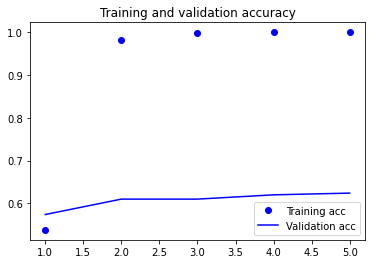

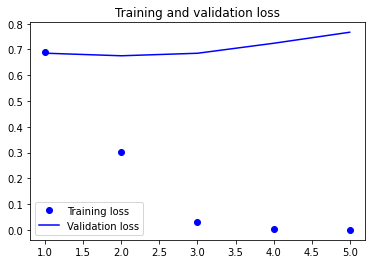

In [125]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Validation accuracy is somewhere in the low 50s. So in this case, pre-trained word embeddings do outperform jointly learned embeddings. 

Finally, evaluate the model on the test data. Do not forget to tokenize the test data.

In [126]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Last but not least, load and evaluate the pre-trained model in the testing data.

In [127]:
model.load_weights('Ex.11.pretrained_GloVe_model.h5')
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 4ms/step - loss: 0.4784 - acc: 0.8190


[0.4783523976802826, 0.8190000057220459]

This is an appalling test accuracy of 54-55%. Working with just a handful of training samples is hard and obviously crazy :-)  Take this is a warning within a lesson-learned!!!

4. in PART II, try to randomly pick different (n=200) training samples and try to find a model. Compare its performance.
    * develop a testplan as you have done before, so you do not change parameters arbitrarily and use a table for the validation results. 


|random samples| type of method | loss function | optimizer |  validation accuracy | no. epochs | batch size|
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 1| binary classification | binary_crossentropy | rmsprop|55% | 10| 32 
| 2| binary classification | binary_crossentropy | rmsprop|63% | 10| 32 
| 3| binary classification | binary_crossentropy | rmsprop|53% | 10| 32 
| 3| binary classification | binary_crossentropy | rmsprop|50% | 5| 32 
| 3| binary classification | binary_crossentropy | rmsprop|51% | 10| 16
| 4| binary classification | binary_crossentropy | rmsprop|61% | 10| 16 
| 5| binary classification | binary_crossentropy | rmsprop|58% | 10| 8 
| 5| binary classification | binary_crossentropy | rmsprop|59% | 5| 8 
| 6| binary classification | binary_crossentropy | rmsprop|59% | 5| 8 

Eine wirklich gute validation accuracy ist aufgrund des geringen train datasets nicht möglich. Jedoch wurde mittels niedrigerer batch size(8) und no. of epochs (5) im Durchschnitt ein besserer Wert von ca 60% erzielt.

5. in PART II, increase the number of training samples for the task-specific embedding and compare it again with the pre-trained embedding. Does it become better? When does it beat the pre-trained embedding?
    * develop a testplan as you have done before, so you do not change parameters arbitrarily and use a table for the validation results

|no training samples| pretrained embedding| type of method | loss function | optimizer |  validation accuracy | no. epochs | batch size|
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |:-: |
| 200|yes| binary classification | binary_crossentropy | rmsprop|55% | 10| 32 
| 200|no |binary classification | binary_crossentropy | rmsprop|57% | 10| 32 
| 300|yes| binary classification | binary_crossentropy | rmsprop|63% | 10| 32 
| 300|no |binary classification | binary_crossentropy | rmsprop|58% | 10| 32 
| 500|yes| binary classification | binary_crossentropy | rmsprop|63% | 10| 32 
| 500|no |binary classification | binary_crossentropy | rmsprop|61% | 10| 32 
| 500|yes| binary classification | binary_crossentropy | rmsprop|64% | 5| 8
| 500|no |binary classification | binary_crossentropy | rmsprop|62% | 5| 8

Wie man anhand der Tabelle erkennen kann, wird die validation accuracy besser je mehr training samples verwendet werden (wuhu wer hätt's gedacht) und die batch size veringert wird bzw. an die Größe der training samples angepasst wird. (bei mehreren tausend samples bräuchte man eine größere Batch size).